In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('../../utils/')
import lec10_graphs as afx

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 6)
rep_seed = 11238

In [3]:
import os
#os.listdir('../../data/')

In [4]:
df = pd.read_csv('../../data/un5_hpcjobschedule.csv').drop(columns='Unnamed: 0')

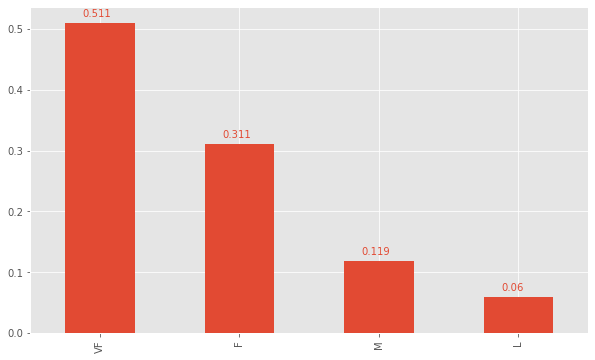

In [5]:
def annotated_barplot(var):
    tmp_values = var.value_counts('%')
    tmp_ax = tmp_values.plot(kind='bar')
    for index, p in enumerate(tmp_ax.patches):
        tmp_ax.annotate(tmp_values[index].round(3), xy=(p.get_x() + .125, p.get_height() + 0.01), color=p.get_facecolor())
annotated_barplot(df['Class'])

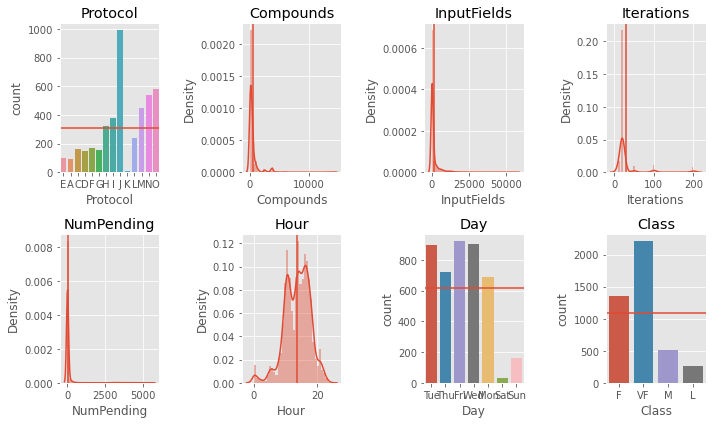

In [6]:
# definimos el dimensionado de nuestra grilla
rows= 2; cols = len(df.columns) // rows
# definimos el tamaño de la figura
afx.plot_describe_variables(df, rows=rows, cols=cols)

In [7]:
# Módulos de preprocesamiento
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
# Módulos de modelos
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

In [8]:
df['very_fast'] = np.where(df['Class'] == 'VF', 1, 0)
df = pd.concat([df,pd.get_dummies(df['Day'], drop_first=True)], axis=1)
df = pd.concat([df, pd.get_dummies(df['Protocol'], drop_first=True)], axis=1)
# Eliminamos las variables originales
df = df.drop(columns=['Protocol', 'Class', 'Day'])

In [9]:
log_vars = ['Compounds', 'InputFields', 'Iterations', 'NumPending']
for i in log_vars:
    df[i] = df[i].apply(lambda x: np.log(x +0.001))

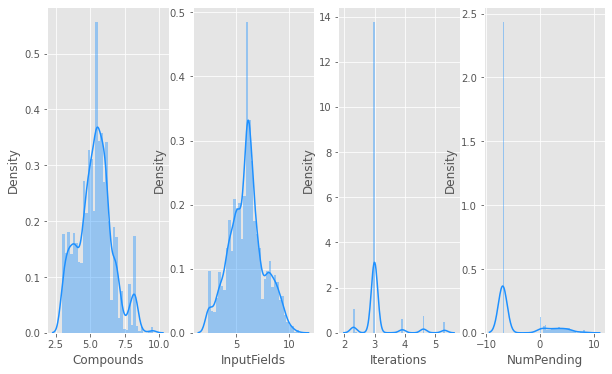

In [10]:
for index, value in enumerate(log_vars):
    plt.subplot(1, 4, index + 1)
    sns.distplot(df[value], color='dodgerblue')

In [11]:
# preservamos en una nueva variable nuestro vector objetivo
y = df.pop('very_fast')

X_eval, X_holdout, y_eval, y_holdout = train_test_split(df, y,test_size=.33, random_state=rep_seed)
X_train, X_test, y_train, y_test = train_test_split(X_eval, y_eval, test_size=.33, random_state=rep_seed)
print(f'Registros holdout: {X_holdout.shape[0]} / Atributos holdout: {X_holdout.shape[1]}')
print(f'Registros training: {X_train.shape[0]} / Atributos training: {X_train.shape[1]}')
print(f'Registros testing: {X_test.shape[0]} / Atributos holdout: {X_test.shape[1]}')

Registros holdout: 1430 / Atributos holdout: 24
Registros training: 1943 / Atributos training: 24
Registros testing: 958 / Atributos holdout: 24


In [14]:
estimators = [('Linear Discriminant Analysis', LinearDiscriminantAnalysis()),
              ('Logistic Regression', LogisticRegression(random_state=rep_seed)),
              ('Decision Tree Classifier', DecisionTreeClassifier(random_state=rep_seed)),
              ('Support Vector Classifier', SVC(kernel='linear', random_state=rep_seed))]

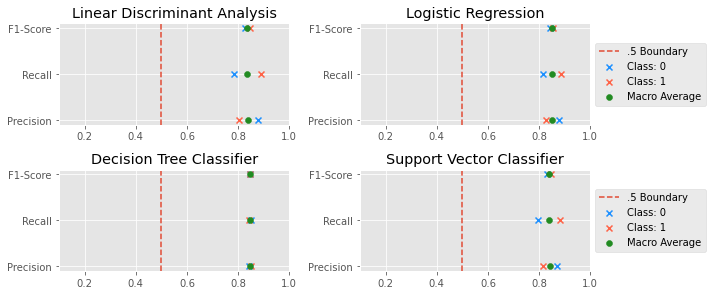

In [15]:
for index, value in enumerate(estimators):
    plt.subplot(3, 2, index + 1)
    plt.title(value[0])
    class_pred = value[1].fit(X_train, y_train).predict(X_test)
    afx.plot_classification_report(y_test, class_pred, dummy_class=True)
    plt.xlim((0.1, 1.0))
    if (index + 1) % 2 == 0:
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()

In [16]:
#help(VotingClassifier)
#voting_classifier = VotingClassifier(estimators, flatten_transform=False).fit(X_train, y_train)

In [19]:
voting_classifier = VotingClassifier(estimators).fit(X_train, y_train)

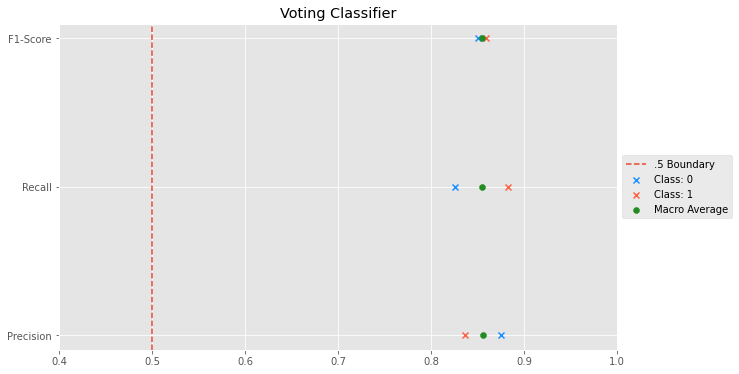

In [20]:
afx.plot_classification_report(y_test,voting_classifier.fit(X_train, y_train).predict(X_test), dummy_class=True)
plt.xlim((0.4, 1.0))
plt.title('Voting Classifier');
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

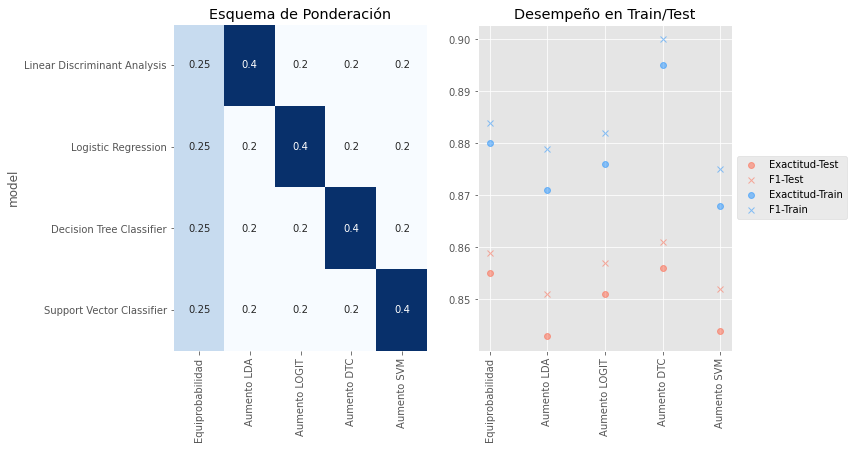

In [21]:
weights_hyperparams = {'Equiprobabilidad': [.25, .25, .25, .25],
                       'Aumento LDA': [.4, .2, .2, .2],
                       'Aumento LOGIT': [.2, .4, .2, .2],
                       'Aumento DTC': [.2, .2, .4, .2],
                       'Aumento SVM': [.2, .2, .2, .4]}
# implementamos la evaluación del modelo
afx.weighting_schedule(voting_classifier, X_train, X_test, y_train, y_test, weights_hyperparams)

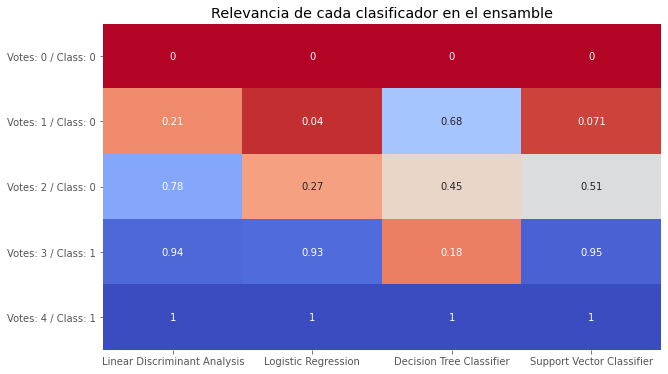

In [22]:
afx.committee_voting(voting_classifier, X_train, X_train, y_train, y_test)
plt.title('Relevancia de cada clasificador en el ensamble');